初始 thetas[:5] = [-1.1690000295639038, 0.8300000429153442, -0.5730000138282776, -2.315000057220459, -1.3830000162124634]

Epoch  1 — loss=1.0936
  thetas[:5] = [-1.1370000839233398, 0.862000048160553, -0.5420000553131104, -2.2829999923706055, -1.3510000705718994]
  sample expval Z = -0.06599999964237213
  → train_acc=0.511, test_acc=0.513
  → train_acc=0.486, test_acc=0.482
  → train_acc=0.483, test_acc=0.475
  → train_acc=0.482, test_acc=0.477

Epoch  5 — loss=1.0558
  thetas[:5] = [-1.1490000486373901, 0.8500000238418579, -0.5540000200271606, -2.2950000762939453, -1.3640000820159912]
  sample expval Z = 0.03200000151991844
  → train_acc=0.480, test_acc=0.479
  → train_acc=0.481, test_acc=0.479
  → train_acc=0.481, test_acc=0.479
  → train_acc=0.482, test_acc=0.477
  → train_acc=0.482, test_acc=0.477

Epoch 10 — loss=1.0536
  thetas[:5] = [-1.152999997138977, 0.8460000157356262, -0.5580000281333923, -2.2990000247955322, -1.3680000305175781]
  sample expval Z = 0.04200000315904617
  → t

/tmp/ipykernel_610158/3474457978.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


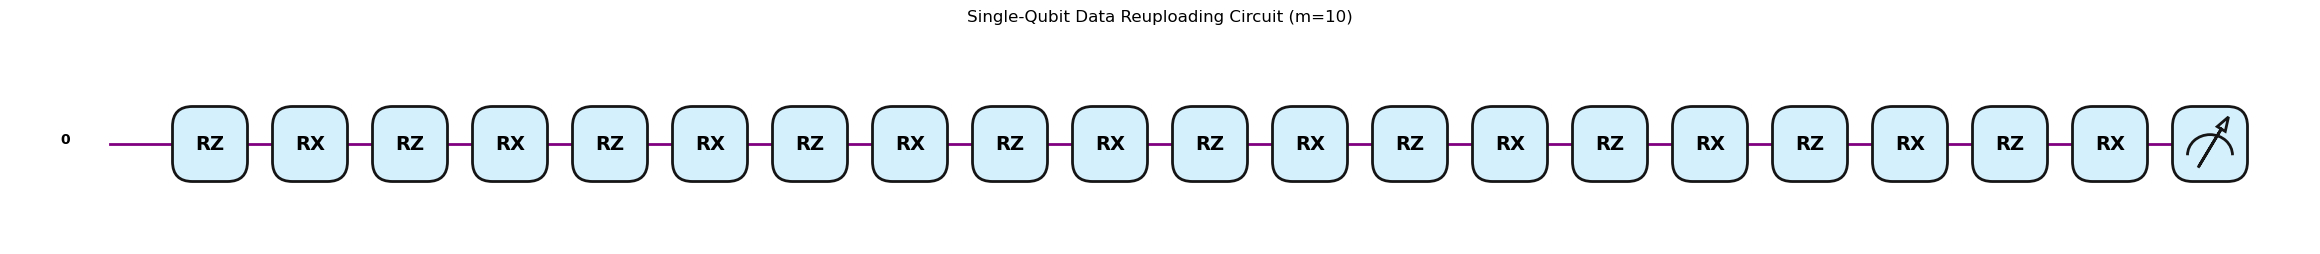

In [ ]:
import jax
import jax.numpy as jnp
import pennylane as qml
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split  # 修正：从 model_selection 导入
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# ─────────────────────────────────────────────────────────────
# 1. 数据准备
# ─────────────────────────────────────────────────────────────
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask   = (y == "0") | (y == "1")
X, y   = X[mask] / 255 * jnp.pi, jnp.array(y[mask].astype(int))

m = 10  # 降到 m=10 维
X = X[:, :m]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ─────────────────────────────────────────────────────────────
# 2. JAX 后端 & QNode 定义
# ─────────────────────────────────────────────────────────────
dev = qml.device("default.qubit.jax", wires=1)

@qml.qnode(dev, interface="jax")
def single_qubit_reupload_jax(x, thetas):
    for i in range(m):
        qml.RZ(x[i], wires=0)
        qml.RX(thetas[i], wires=0)
    return qml.expval(qml.PauliZ(0))

# 批量向量化
batch_qnode = jax.vmap(single_qubit_reupload_jax, in_axes=(0, None))

# ─────────────────────────────────────────────────────────────
# 3. JIT 加速的损失与梯度
# ─────────────────────────────────────────────────────────────
def loss_fn(thetas, Xb, yb):
    preds = batch_qnode(Xb, thetas)
    targets = 1 - 2 * yb
    return jnp.mean((preds - targets) ** 2)

loss_and_grad = jax.jit(jax.value_and_grad(loss_fn))

# ─────────────────────────────────────────────────────────────
# 4. 初始化 & 训练循环
# ─────────────────────────────────────────────────────────────
key    = jax.random.PRNGKey(0)
thetas = jax.random.normal(key, (m,)) * jnp.pi
lr     = 0.1
epochs = 20

print("初始 thetas[:5] =", jnp.round(thetas[:5], 3).tolist())
for epoch in range(1, epochs + 1):
    # 一步 JIT 编译的优化
    loss_val, grad = loss_and_grad(thetas, X_train, y_train)
    thetas = thetas - lr * grad

    if epoch % 5 == 0 or epoch == 1:
        sample = single_qubit_reupload_jax(X_train[0], thetas)
        print(f"\nEpoch {epoch:2d} — loss={loss_val:.4f}")
        print("  thetas[:5] =", jnp.round(thetas[:5], 3).tolist())
        print("  sample expval Z =", float(jnp.round(sample, 3)))

    # 准确率
    train_preds = batch_qnode(X_train, thetas) > 0
    test_preds  = batch_qnode(X_test,  thetas) > 0
    train_acc = jnp.mean(train_preds == (y_train == 0))
    test_acc  = jnp.mean(test_preds  == (y_test  == 0))
    print(f"  → train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

print("\n训练结束，最终 thetas[:5] =", jnp.round(thetas[:5], 3).tolist())

# ─────────────────────────────────────────────────────────────
# 5. 彩色电路可视化
# ─────────────────────────────────────────────────────────────
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(
    single_qubit_reupload_jax,
    wire_order=[0],
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "purple", "linewidth": 2},
    label_options={"size": 10, "color": "black"},
    max_length=100
)(X_train[0], thetas)

ax.set_title("Single‑Qubit Data Reuploading Circuit (m=10)", pad=16)
plt.tight_layout()
plt.show()
